In [1]:
import numpy as np
import os
from utils import find_path_to_next_simulation
from MODSIM import initialize_dynamic_scene_with_random_tracks, perform_time_steps, create_and_place_simple_legacy_camera
from errorGenerator import ErrorGenerator
from datatypes.cameraRig import CameraRig
from datatypes.virtualCamera import VirtualCamera

from visualize import visualize_projections_json_mov, visualize_bounding_boxes_json_mov, visualize_camera_pose_in_dsg_mov, visualize_dynamic_scene_mov, visualize_distorted_bounding_boxes_json_mov


In [2]:
# Camera types: 'STATIC_LEGACY', 'DYNAMIC'
STATIC_LEGACY = 'STATIC_LEGACY'
DYNAMIC = 'DYNAMIC'

CAMERA_TYPE = STATIC_LEGACY

In [3]:
ERROR_CONFIG_PATH = 'detector_stats_config.yaml'
NUMBER_OF_VESSELS = 6
WRITE_TO_JSON = True
T_START = 0
T_END = 100
VISUALIZE=True


In [4]:
# Find folder to save simultation trial to
simulation_folder = find_path_to_next_simulation()
simulation_folder

'./simulations/1/'

# Initialize MODSIM

In [5]:
# Dynamic scene
dsg = initialize_dynamic_scene_with_random_tracks(NUMBER_OF_VESSELS, writeToJson=WRITE_TO_JSON, path=simulation_folder)
vessels = dsg.get_vessels()

## Error generator
errorGenerator = ErrorGenerator(ERROR_CONFIG_PATH)


In [6]:
if CAMERA_TYPE == STATIC_LEGACY:
    ##### Static Camera #####
    # Create simple legacy camera and place it in the dynamic scene
    camera = create_and_place_simple_legacy_camera(dsg.get_larges_radius(), dsg.get_path_centre())
    camera_rig = CameraRig(camera)

In [7]:
if CAMERA_TYPE == DYNAMIC:
    ###### Dynamic Camera ######
    focal_length = 50*10**-3
    image_bounds = (3600, 2400) # Pixels (x,y)
    film_size = (36*10**-3, 24*10**-3)
    px = film_size[0]/image_bounds[0]
    py = film_size[1]/image_bounds[1]
    principal_point = (image_bounds[0]/2,image_bounds[1]/2)
    width_of_sensor = 36*10**-3 # Width of sensor
    roll_vcf = 0
    yaw_vcf = 0
    pitch_vcf = np.pi / 20
    vessel = vessels[3]
    pos_vcf = np.array([vessel.get_length()/2, 0, vessel.get_air_draft()/2])

    camera = VirtualCamera(focal_length, px, py, principal_point, image_bounds)
    camera.place_camera_on_vessel(pos_vcf, roll_vcf, pitch_vcf, yaw_vcf)
    camera_rig = CameraRig(camera, vessel)

# Perform time steps

In [8]:
pps, bbs, eBBs = perform_time_steps(T_START, T_END, dsg, errorGenerator, camera_rig, writeToJson=WRITE_TO_JSON, path=simulation_folder)

# Visualize

Moviepy - Building video ./simulations/1/dynamicScene.mp4.
Moviepy - Writing video ./simulations/1/dynamicScene.mp4



Moviepy - Done !
Moviepy - video ready ./simulations/1/dynamicScene.mp4
Moviepy - Building video ./simulations/1/camera_position.mp4.
Moviepy - Writing video ./simulations/1/camera_position.mp4



Moviepy - Done !
Moviepy - video ready ./simulations/1/camera_position.mp4
Moviepy - Building video ./simulations/1/projected_points.mp4.
Moviepy - Writing video ./simulations/1/projected_points.mp4



Moviepy - Done !
Moviepy - video ready ./simulations/1/projected_points.mp4
Moviepy - Building video ./simulations/1/boundingBoxes.mp4.
Moviepy - Writing video ./simulations/1/boundingBoxes.mp4



Moviepy - Done !
Moviepy - video ready ./simulations/1/boundingBoxes.mp4
Moviepy - Building video ./simulations/1/distortedBoundingBoxes.mp4.
Moviepy - Writing video ./simulations/1/distortedBoundingBoxes.mp4



Moviepy - Done !
Moviepy - video ready ./simulations/1/distortedBoundingBoxes.mp4


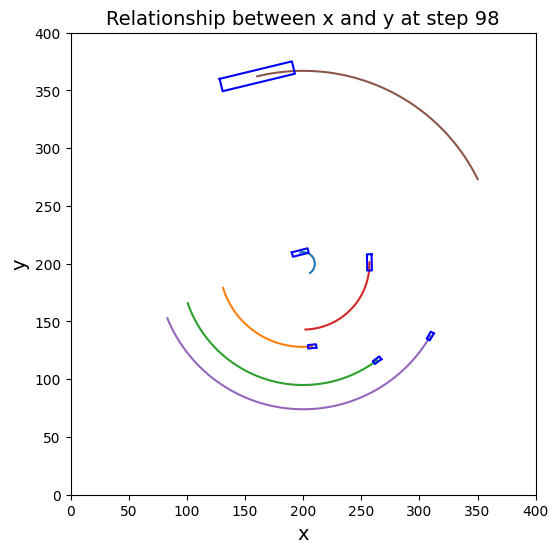

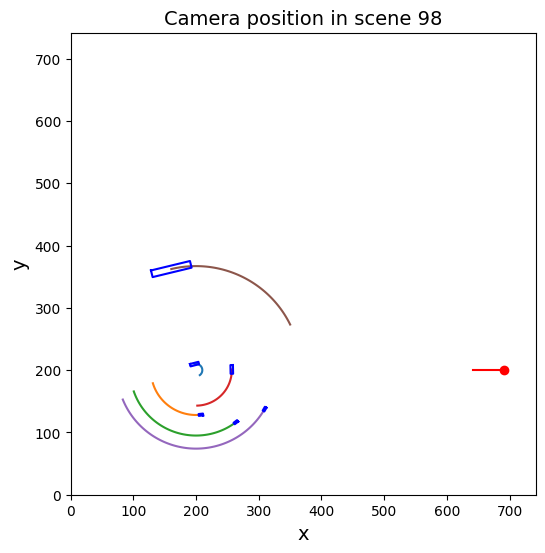

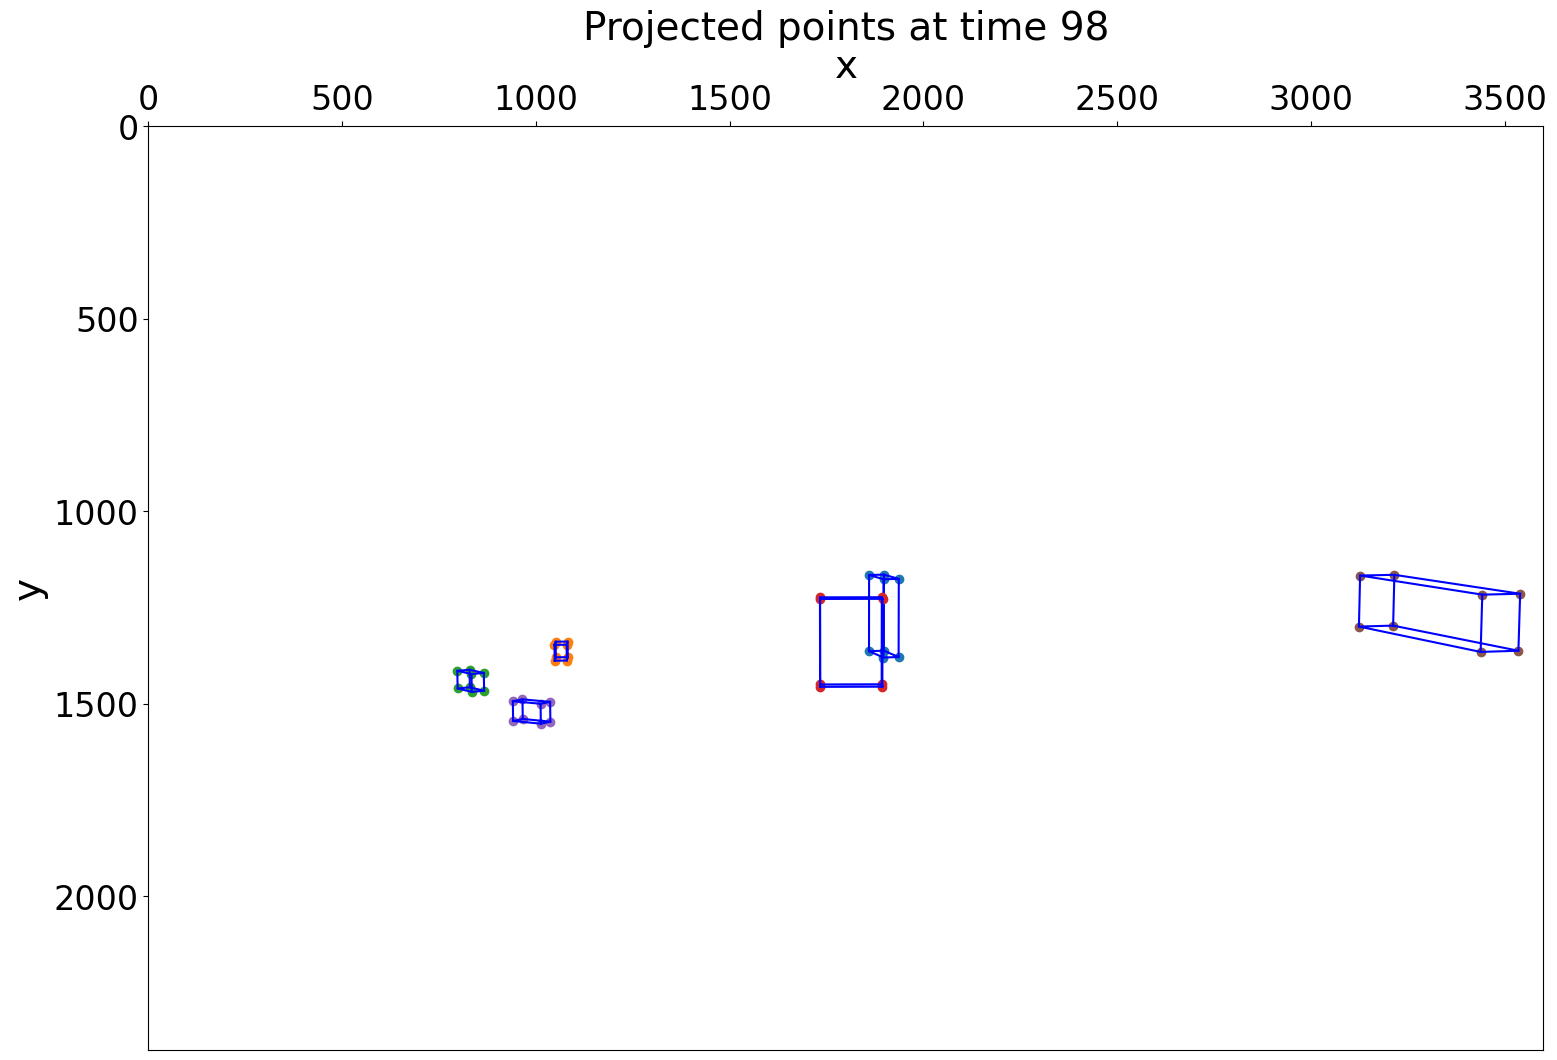

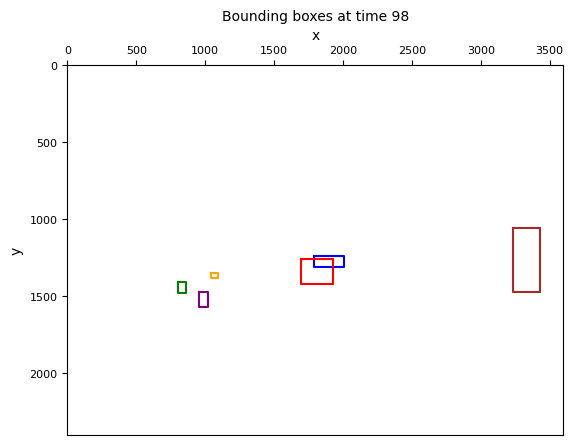

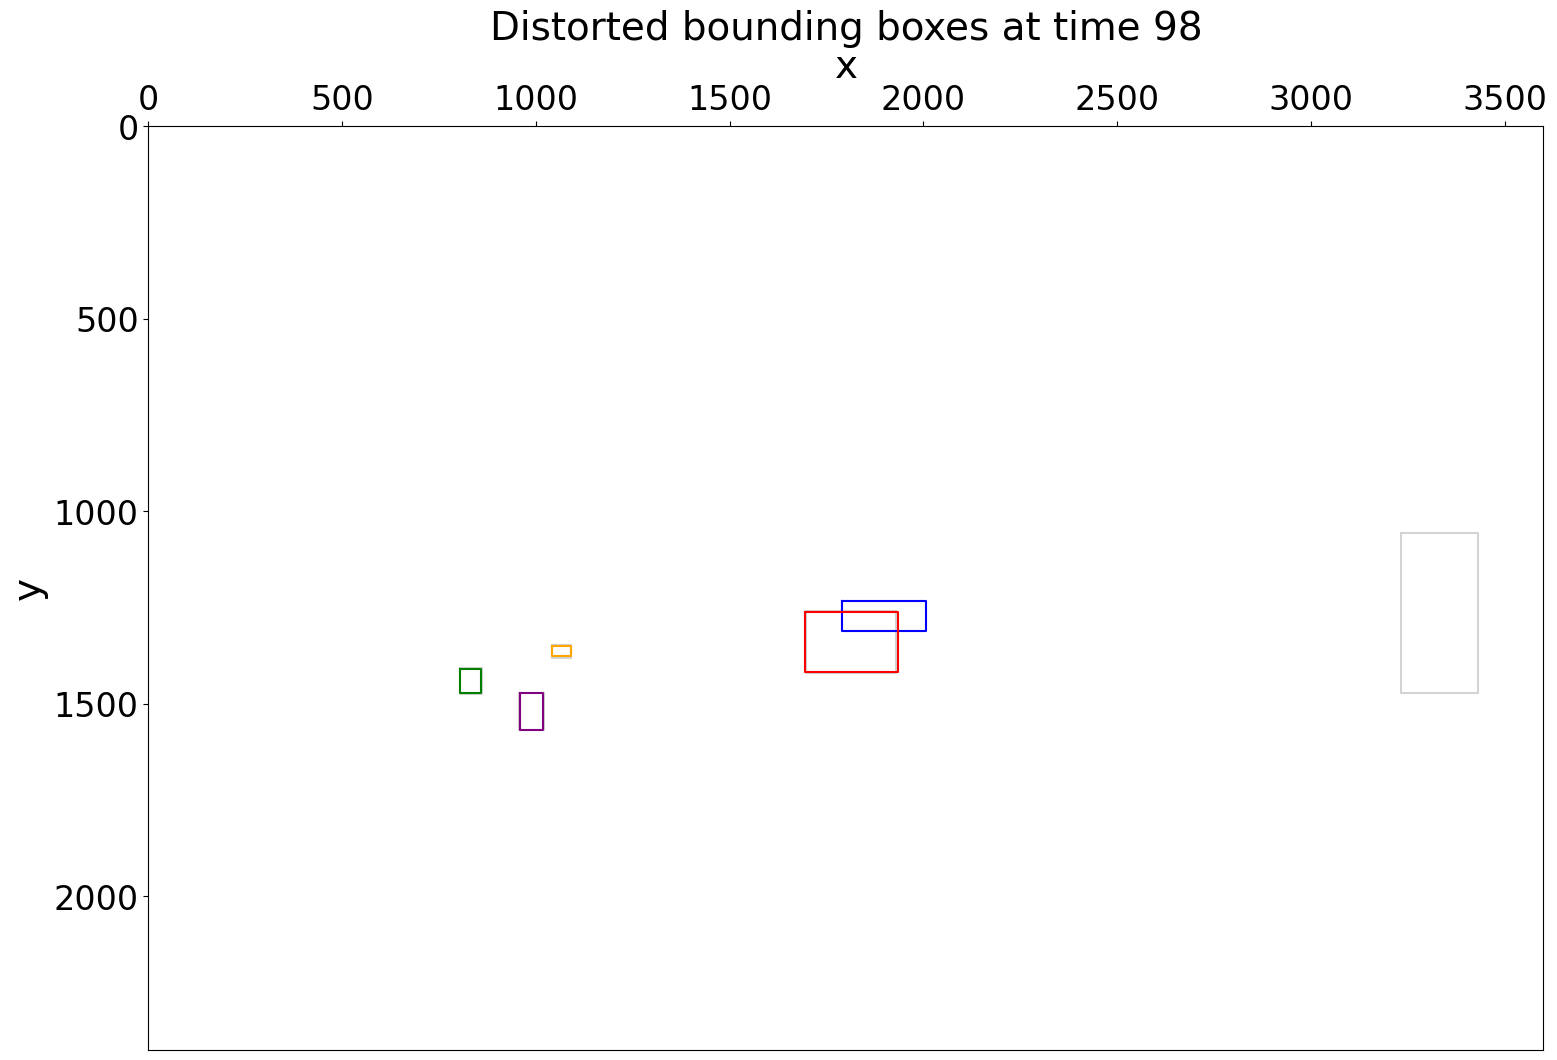

In [9]:
# Visualize from json files
if VISUALIZE:
    pps_path = os.path.join(simulation_folder, 'projectedPoints.json')
    bbs_path = os.path.join(simulation_folder, 'boundingBoxes.json')
    eBBs_path = os.path.join(simulation_folder, 'distortedBoundingBoxes.json')
    visualize_dynamic_scene_mov(vessels, folder_path=simulation_folder)
    visualize_camera_pose_in_dsg_mov(camera_rig, vessels, folder_path=simulation_folder)
    visualize_projections_json_mov(pps_path, camera_rig.camera.image_bounds, folder_path=simulation_folder)
    visualize_bounding_boxes_json_mov(bbs_path, camera_rig.camera.image_bounds, folder_path=simulation_folder)
    visualize_distorted_bounding_boxes_json_mov(eBBs_path, camera_rig.camera.image_bounds, show_original_BBS=True, original_BBs_path=bbs_path, folder_path=simulation_folder)
